In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, log_loss, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam


In [47]:
data_sensors_utrecht_path = '../Sensor data Utrecht.csv'
data_sensors_utrecht = pd.read_csv(data_sensors_utrecht_path, delimiter=';')

# Convert Timestamp column to datetime
data_sensors_utrecht['date'] = pd.to_datetime(data_sensors_utrecht['date'], errors='coerce', utc=True)


In [51]:
data_sensors_neude = data_sensors_utrecht[data_sensors_utrecht['location name'] == 'Neude']
data_sensors_neude



,date,status,sensor id,location name,city name
4057,2024-10-16 09:57:07+00:00,False,863213040215571,Neude,Utrecht
4081,2024-10-16 10:44:20+00:00,True,863213040215571,Neude,Utrecht
4082,2024-10-16 10:44:31+00:00,False,863213040215571,Neude,Utrecht
4095,2024-10-16 11:03:00+00:00,True,863213040215571,Neude,Utrecht
4096,2024-10-16 11:03:18+00:00,False,863213040215571,Neude,Utrecht
...,...,...,...,...,...
139901,2025-06-16 10:09:09+00:00,True,863213040215571,Neude,Utrecht
139986,2025-06-16 14:03:56+00:00,True,863213040215571,Neude,Utrecht
140250,2025-06-16 17:57:47+00:00,True,863213040215571,Neude,Utrecht
140493,2025-06-16 21:51:28+00:00,True,863213040215571,Neude,Utrecht


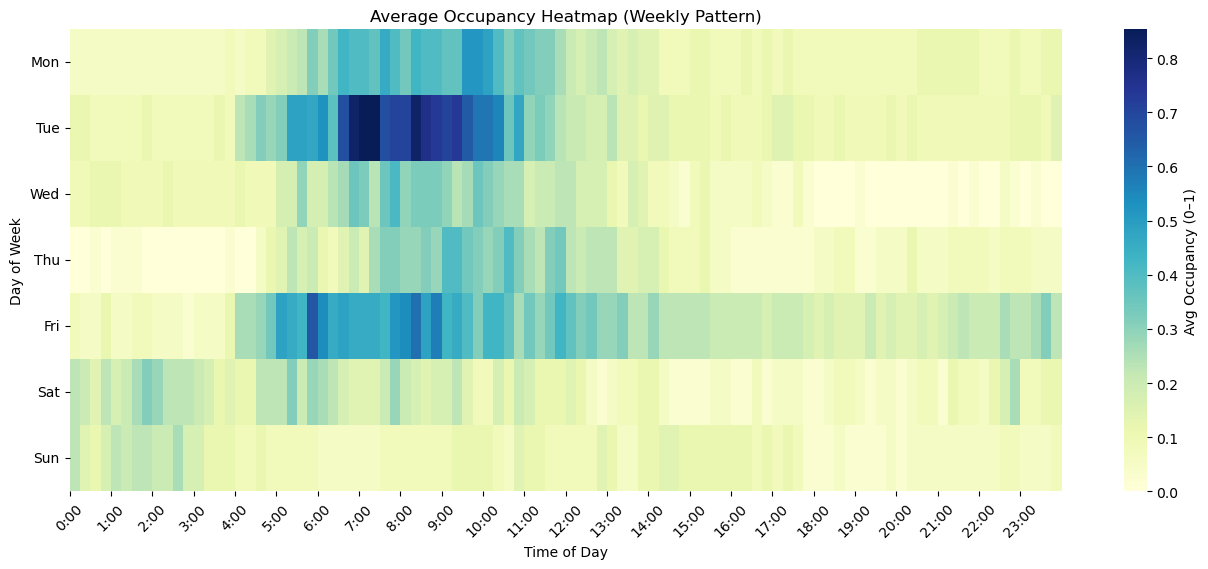

In [65]:
heatmap_data = data_sensors_neude.copy()

heatmap_data['status'] = heatmap_data['status'].astype(int)
heatmap_data = heatmap_data.sort_values('date')
heatmap_data = heatmap_data.set_index('date').resample('15min').ffill().reset_index()
heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek
heatmap_data['slot'] = heatmap_data['date'].dt.hour * 4 + heatmap_data['date'].dt.minute // 15

heatmap_data = heatmap_data.groupby(['day_of_week','slot'])['status'].mean().unstack()
heatmap_data = heatmap_data.astype(float)  # force numeric

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label':'Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i) + ":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()

In [99]:
# Copy original dataset
data = data_sensors_neude.copy()

# Ensure integer status
data['status'] = data['status'].astype(int)

# Regularize timeseries
data = data.sort_values('date')
data = data.set_index('date').resample('15min').ffill().reset_index()

# Time features
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['day_of_month'] = data['date'].dt.day
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
data['time_of_day'] = data['slot'] / 96
data['dow_slot'] = data['day_of_week'].astype(str) + "_" + data['slot'].astype(str)

# Lag features
lags = [1, 2, 3, 4, 12, 24, 96]
for lag in lags:
    data[f'status_lag_{lag}'] = data['status'].shift(lag)

# Rolling features
rolling_windows = {
    '1h': 4,
    '3h': 12, 
    '6h': 24, 
    '1d': 96, 
    '1w': 672
}
for name, window in rolling_windows.items():
    data[f'status_roll_mean_{name}'] = data['status'].rolling(window).mean().shift(1)
    data[f'status_roll_max_{name}'] = data['status'].rolling(window).max().shift(1)
    data[f'status_roll_min_{name}'] = data['status'].rolling(window).min().shift(1)
    data[f'status_roll_sum_{name}'] = data['status'].rolling(window).sum().shift(1)

# Drop NaNs after lag/rolling
data = data.dropna().reset_index(drop=True)


In [100]:
features = [
    'day_of_week','month','day_of_month','is_weekend','time_of_day','dow_slot',
    'status_lag_1','status_lag_2','status_lag_3','status_lag_4',
    'status_lag_12','status_lag_24','status_lag_96',
    'status_roll_mean_1h','status_roll_max_1h','status_roll_min_1h','status_roll_sum_1h',
    'status_roll_mean_3h','status_roll_max_3h','status_roll_min_3h','status_roll_sum_3h',
    'status_roll_mean_6h','status_roll_max_6h','status_roll_min_6h','status_roll_sum_6h',
    'status_roll_mean_1d','status_roll_max_1d','status_roll_min_1d','status_roll_sum_1d',
    'status_roll_mean_1w','status_roll_max_1w','status_roll_min_1w','status_roll_sum_1w'
]

X = data[features]
X['dow_slot'] = X['dow_slot'].astype('category')  # categorical encoding
y = data['status'].astype(float)  # regression target (probability 0–1)

# Train/test split (last 20% is test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


C:\Users\olafh\AppData\Local\Temp\ipykernel_12256\1183365586.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dow_slot'] = X['dow_slot'].astype('category')  # categorical encoding


In [110]:
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    enable_categorical=True,
    random_state=42,
)

model.fit(X_train, y_train)

# Predictions on test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f} | R²: {r2:.4f}")


Test MSE: 0.0650 | R²: 0.5780


In [111]:
# Get last history needed for rolling features
max_lag = max(lags)
max_window = max(rolling_windows.values())
n_rows_needed = max(max_lag, max_window)

last_data = data.tail(n_rows_needed).copy().reset_index(drop=True)

forecast_horizon = 96 * 7  # 1 week (15min slots)
pred_timestamps = []
pred_values = []

current_data = last_data.copy()

for i in range(forecast_horizon):
    last_timestamp = current_data['date'].iloc[-1] + pd.Timedelta(minutes=15)
    
    # Feature engineering for this step
    features_step = {
        'day_of_week': last_timestamp.dayofweek,
        'month': last_timestamp.month,
        'day_of_month': last_timestamp.day,
        'is_weekend': int(last_timestamp.dayofweek >= 5),
        'slot': last_timestamp.hour * 4 + last_timestamp.minute // 15,
    }
    features_step['time_of_day'] = features_step['slot'] / 96
    features_step['dow_slot'] = f"{features_step['day_of_week']}_{features_step['slot']}"
    
    # Add lags
    for lag in lags:
        features_step[f'status_lag_{lag}'] = current_data['status'].iloc[-lag]
    
    # Add rolling stats
    for name, window in rolling_windows.items():
        features_step[f'status_roll_mean_{name}'] = current_data['status'].iloc[-window:].mean()
        features_step[f'status_roll_max_{name}'] = current_data['status'].iloc[-window:].max()
        features_step[f'status_roll_min_{name}'] = current_data['status'].iloc[-window:].min()
        features_step[f'status_roll_sum_{name}'] = current_data['status'].iloc[-window:].sum()
    
    # Prediction
    X_pred = pd.DataFrame([features_step])[features]
    X_pred['dow_slot'] = X_pred['dow_slot'].astype('category')
    y_next = model.predict(X_pred)[0]
    
    pred_timestamps.append(last_timestamp)
    pred_values.append(y_next)
    
    # Append prediction to current_data
    new_row = pd.DataFrame({'date':[last_timestamp], 'status':[y_next]})
    current_data = pd.concat([current_data, new_row], ignore_index=True)

# Forecast dataframe
forecast_df = pd.DataFrame({
    'date': pred_timestamps,
    'status_pred': pred_values
})


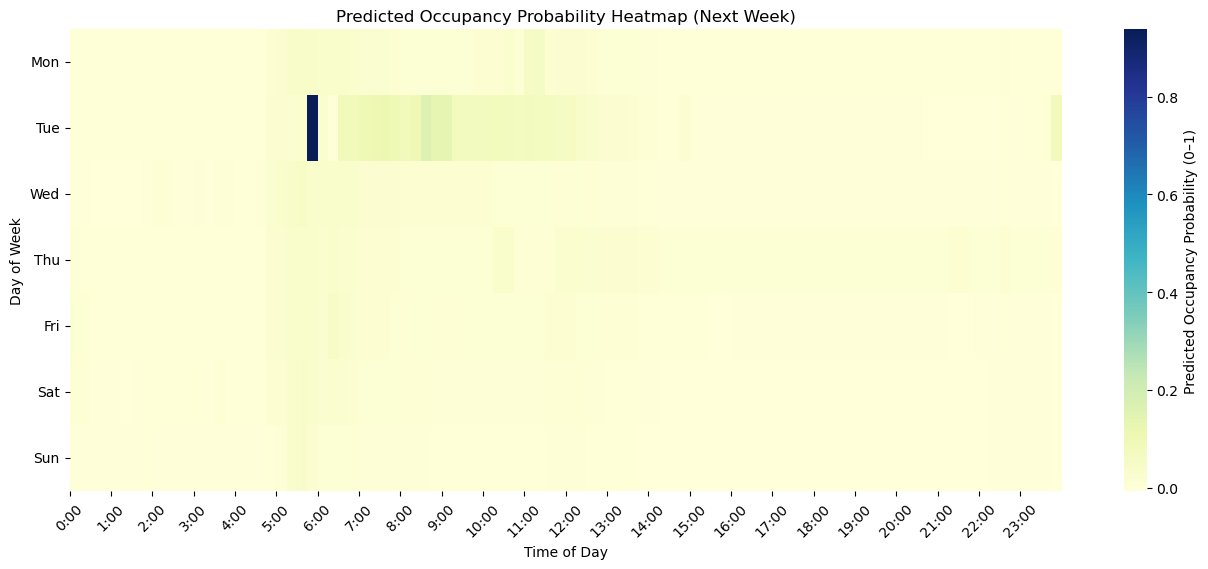

In [112]:
forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_matrix, cmap="YlGnBu", cbar_kws={'label':'Predicted Occupancy Probability (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Occupancy Probability Heatmap (Next Week)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i)+":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()


In [113]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    enable_categorical=True,
    random_state=42
)

model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Evaluate
logloss = log_loss(y_test, y_pred_prob)
roc = roc_auc_score(y_test, y_pred_prob)
print(f"Test LogLoss: {logloss:.4f} | ROC-AUC: {roc:.4f}")


Test LogLoss: 0.2227 | ROC-AUC: 0.9379


In [114]:
# History needed for lags/rolling
max_lag = max(lags)
max_window = max(rolling_windows.values())
n_rows_needed = max(max_lag, max_window)

last_data = data.tail(n_rows_needed).copy().reset_index(drop=True)

forecast_horizon = 96 * 7  # 1 week
pred_timestamps = []
pred_probs = []

current_data = last_data.copy()

for i in range(forecast_horizon):
    last_timestamp = current_data['date'].iloc[-1] + pd.Timedelta(minutes=15)
    
    # Features for this slot
    features_step = {
        'day_of_week': last_timestamp.dayofweek,
        'month': last_timestamp.month,
        'day_of_month': last_timestamp.day,
        'is_weekend': int(last_timestamp.dayofweek >= 5),
        'slot': last_timestamp.hour * 4 + last_timestamp.minute // 15,
    }
    features_step['time_of_day'] = features_step['slot'] / 96
    features_step['dow_slot'] = f"{features_step['day_of_week']}_{features_step['slot']}"
    
    # Lags
    for lag in lags:
        features_step[f'status_lag_{lag}'] = current_data['status'].iloc[-lag]
    
    # Rolling stats
    for name, window in rolling_windows.items():
        features_step[f'status_roll_mean_{name}'] = current_data['status'].iloc[-window:].mean()
        features_step[f'status_roll_max_{name}'] = current_data['status'].iloc[-window:].max()
        features_step[f'status_roll_min_{name}'] = current_data['status'].iloc[-window:].min()
        features_step[f'status_roll_sum_{name}'] = current_data['status'].iloc[-window:].sum()
    
    # Prediction
    X_pred = pd.DataFrame([features_step])[features]
    X_pred['dow_slot'] = X_pred['dow_slot'].astype('category')
    prob_next = model.predict_proba(X_pred)[0,1]
    
    pred_timestamps.append(last_timestamp)
    pred_probs.append(prob_next)
    
    # Append simulated new row (use prob as status proxy)
    new_row = pd.DataFrame({'date':[last_timestamp], 'status':[prob_next]})
    current_data = pd.concat([current_data, new_row], ignore_index=True)

# Forecast dataframe
forecast_df = pd.DataFrame({
    'date': pred_timestamps,
    'probability': pred_probs
})


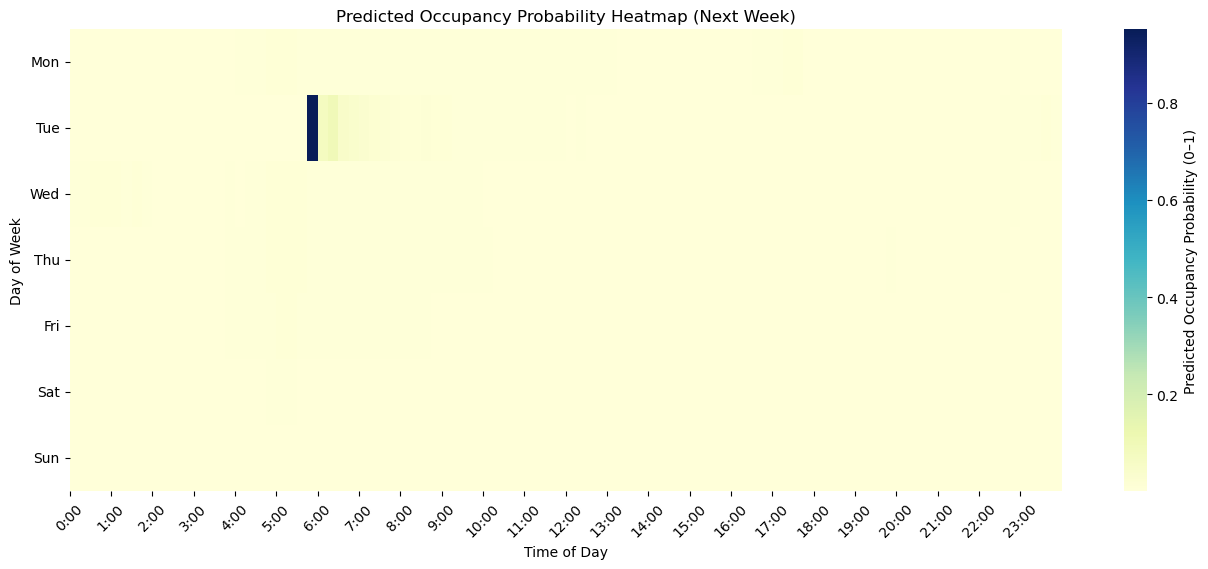

In [115]:
forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['probability'].mean().unstack()

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_matrix, cmap="YlGnBu", cbar_kws={'label':'Predicted Occupancy Probability (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Occupancy Probability Heatmap (Next Week)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i)+":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()
